In [2]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

from SPARKpy import *

In [3]:
data_dir = '../../data/processed_data/Stahl-BC/'
save_dir = '../../results/Stahl-BC/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

### Breast cancer data

In [3]:
# slice 1 
s1_count = pd.read_csv(data_dir + 'stahl_bc_slice1.csv', index_col=0, header=0)
s1_coor = pd.read_csv(data_dir + 'stahl_bc_slice1_coor.csv', index_col=None, header=None)
s1_count.shape, s1_coor.shape

((254, 7998), (254, 2))

In [4]:
# slice 2
s2_count = pd.read_csv(data_dir + 'stahl_bc_slice2.csv', index_col=0, header=0)
s2_coor = pd.read_csv(data_dir + 'stahl_bc_slice2_coor.csv', index_col=None, header=None)
s2_count.shape, s2_coor.shape

((251, 7713), (251, 2))

In [5]:
adata1 = sc.AnnData(csr_matrix(s1_count.values))
adata1.obs_names = s1_count.index
adata1.var_names = s1_count.columns
adata1.obsm['spatial'] = s1_coor.values

adata2 = sc.AnnData(csr_matrix(s2_count.values))
adata2.obs_names = s2_count.index
adata2.var_names = s2_count.columns
adata2.obsm['spatial'] = s2_coor.values

adata1, adata2

(AnnData object with n_obs × n_vars = 254 × 7998
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 251 × 7713
     obsm: 'spatial')

### Filtering

In [6]:
spark_filter(adata1)
spark_filter(adata2)
adata1, adata2

(AnnData object with n_obs × n_vars = 254 × 5485
     obs: 'n_counts'
     var: 'n_cells'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 250 × 5262
     obs: 'n_counts'
     var: 'n_cells'
     obsm: 'spatial')

### Find common genes

In [7]:
common_gene_list = [gene for gene in adata1.var_names if gene in adata2.var_names]
adata1_common = adata1[:, common_gene_list].copy()
adata2_common = adata2[:, common_gene_list].copy()
adata1_common, adata2_common

(AnnData object with n_obs × n_vars = 254 × 4860
     obs: 'n_counts'
     var: 'n_cells'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 250 × 4860
     obs: 'n_counts'
     var: 'n_cells'
     obsm: 'spatial')

### Alignment

In [8]:
import paste as pst
from paste2 import PASTE2, projection
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

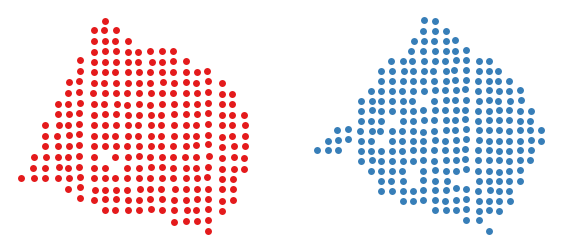

In [9]:
# filtered image
file_format = 'png'
slice_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']

# plot raw slices
fig, axs = plt.subplots(1, 2,figsize=(7,3))
pst.plot_slice(adata1_common,slice_colors[0],ax=axs[0])
pst.plot_slice(adata2_common,slice_colors[1],ax=axs[1])

# plt.savefig(save_dir + f'filtered_stahl_bc.{file_format}')
plt.show()

In [10]:
# paste_alignment
# pi12 = pst.pairwise_align(adata1_common, adata2_common)
pi12 = PASTE2.partial_pairwise_align(adata1_common, adata2_common, s=0.99)

slices, pis = [adata1_common, adata2_common], [pi12]
# new_slices = pst.stack_slices_pairwise(slices, pis)
new_slices = projection.partial_stack_slices_pairwise(slices, pis)
new_slices[0], new_slices[1]

PASTE2 starts...
Starting GLM-PCA...
Iteration: 0 | deviance=1.2587E+6
Iteration: 1 | deviance=1.2587E+6
Iteration: 2 | deviance=1.0908E+6
Iteration: 3 | deviance=9.6194E+5
Iteration: 4 | deviance=9.0005E+5
Iteration: 5 | deviance=8.6488E+5
Iteration: 6 | deviance=8.4492E+5
Iteration: 7 | deviance=8.3226E+5
Iteration: 8 | deviance=8.2350E+5
Iteration: 9 | deviance=8.1705E+5
Iteration: 10 | deviance=8.1206E+5
Iteration: 11 | deviance=8.0806E+5
Iteration: 12 | deviance=8.0477E+5
Iteration: 13 | deviance=8.0202E+5
Iteration: 14 | deviance=7.9968E+5
Iteration: 15 | deviance=7.9766E+5
Iteration: 16 | deviance=7.9589E+5
Iteration: 17 | deviance=7.9434E+5
Iteration: 18 | deviance=7.9297E+5
Iteration: 19 | deviance=7.9174E+5
Iteration: 20 | deviance=7.9065E+5
Iteration: 21 | deviance=7.8967E+5
Iteration: 22 | deviance=7.8879E+5
Iteration: 23 | deviance=7.8799E+5
Iteration: 24 | deviance=7.8728E+5
Iteration: 25 | deviance=7.8664E+5
Iteration: 26 | deviance=7.8606E+5
Iteration: 27 | deviance=7.8

(AnnData object with n_obs × n_vars = 254 × 4860
     obs: 'n_counts'
     var: 'n_cells'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 250 × 4860
     obs: 'n_counts'
     var: 'n_cells'
     obsm: 'spatial')

In [11]:
adata1_common.write_h5ad(save_dir + 'slice1_bc_filtered_aligned.h5ad')
adata2_common.write_h5ad(save_dir + 'slice2_bc_filtered_aligned.h5ad')

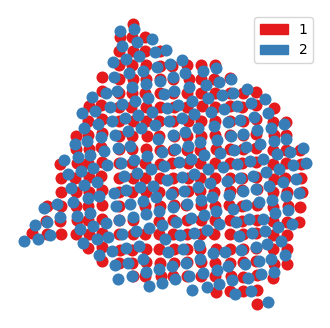

In [12]:
# plot paste_alignment results
file_format = 'png'
plt.figure(figsize=(4,4))
for i in range(len(new_slices)):
    pst.plot_slice(new_slices[i],slice_colors[i], s=300)
plt.legend(handles=[mpatches.Patch(color=slice_colors[0], label='1'),
                    mpatches.Patch(color=slice_colors[1], label='2')])
plt.gca().invert_yaxis()
plt.axis('off')

# plt.savefig(save_dir + f'paste_alignment_stahl_bc.{file_format}')
plt.show()

### Plot umap

In [15]:
from umap.umap_ import UMAP
from sklearn.decomposition import PCA
from plot_utils import plot_umap
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

reducer = UMAP(n_neighbors=30, metric="correlation", min_dist=0.3, random_state=1234)
pca = PCA(n_components=50, random_state=1234)

adata1_common = sc.read_h5ad(save_dir + 'slice1_bc_filtered_aligned.h5ad')
adata2_common = sc.read_h5ad(save_dir + 'slice2_bc_filtered_aligned.h5ad')
adata_concat = adata1_common.concatenate(adata2_common, batch_key='batches', batch_categories=['slice1', 'slice2'])
sc.pp.log1p(adata_concat)
sc.pp.normalize_total(adata_concat, target_sum=1e4)
X_pca = pca.fit_transform(adata_concat.X)
umap_embedding = reducer.fit_transform(X_pca)

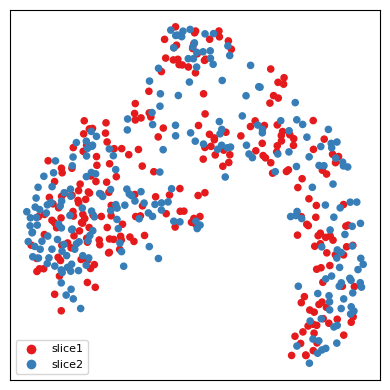

In [16]:
file_format = 'pdf'
b_cmap = {"slice1": '#e41a1c', "slice2": '#377eb8'}
plot_umap(adata_concat, umap_embedding, b_cmap, "batches", ['slice1', 'slice2'],
          figsize=(4, 4), markersize=8, fontsize=8, legendtitlesize=10, legend_title=None, loc="lower left", titlesize=12, title=None,
          save_path=save_dir+f"raw_umap.{file_format}", save=True, show=True)

### Run SPARK for each slice seperately

In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

from SPARKpy import *

data_dir = '../../data/processed_data/Stahl-BC/'
save_dir = '../../results/Stahl-BC/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [2]:
adata1_common = sc.read_h5ad(save_dir + 'slice1_bc_filtered_aligned.h5ad')
adata2_common = sc.read_h5ad(save_dir + 'slice2_bc_filtered_aligned.h5ad')
adata_concat = adata1_common.concatenate(adata2_common, batch_key='batches', batch_categories=['slice1', 'slice2'])
adata_concat.obs_names_make_unique()
adata1_common, adata2_common, adata_concat

(AnnData object with n_obs × n_vars = 254 × 4860
     obs: 'n_counts'
     var: 'n_cells'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 250 × 4860
     obs: 'n_counts'
     var: 'n_cells'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 504 × 4860
     obs: 'n_counts', 'batches'
     var: 'n_cells-slice1', 'n_cells-slice2'
     obsm: 'spatial')

#### slice 1

In [3]:
model = SPARKpy(adata1_common, verbose=False)
p_value_df_1 = model.fit_spark() 
p_value_df_1.to_csv(save_dir + 'p_values_spark_slice1.csv', index=True)
p_value_df_1

gau0          cos0          gau1          cos1  \
GAPDH     2.220446e-16  9.999452e-01  1.824096e-13  9.638499e-01   
UBE2G2    6.710551e-03  3.276992e-10  1.469494e-01  5.555091e-03   
MAPKAPK2  5.752147e-02  5.298452e-01  2.225455e-02  9.549343e-01   
NDUFA7    9.042334e-10  3.768375e-06  2.083904e-04  4.717762e-04   
ASNA1     0.000000e+00  0.000000e+00  0.000000e+00  1.110223e-16   
...                ...           ...           ...           ...   
TMX2      1.498071e-03  1.118065e-09  6.542111e-02  5.664885e-09   
DUSP10    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
TMEM126A  6.327466e-06  7.788888e-10  9.435126e-04  5.807567e-04   
VCPIP1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
DIP2C     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                  gau2          cos2          gau3          cos3  \
GAPDH     2.412435e-09  8.579487e-01  3.827874e-06  1.126843e-01   
UBE2G2    4.287504e-01  2.747688e-02  4.329369e-01  2.407954e-03   
MAPKAPK2  1.779403e-02  2.894451e-01  2.382685e-02  8.706930e-01   
NDUFA7    1.104801e-02  1.807642e-06  9.614506e-02  4.539325e-07   
ASNA1     0.000000e+00  6.589618e-07  1.110223e-16  4.440892e-16   
...                ...           ...           ...           ...   
TMX2      1.966035e-01  4.336541e-08  2.218558e-01  3.443151e-04   
DUSP10    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
TMEM126A  7.901808e-03  2.086742e-09  1.835594e-02  2.889436e-02   
VCPIP1    0.000000e+00  0.000000e+00  3.663736e-15  1.287037e-11   
DIP2C     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                  gau4          cos4      p_values  adj_p_values  
GAPDH     2.079975e-04  7.359683e-06  2.275957e-15  7.072048e-14  
UBE2G2    3.606647e-01  1.473493e-02  3.276991e-09  1.017537e-07  
MAPKAPK2  3.846879e-02  2.495989e-01  6.100425e-02  5.595185e-01  
NDUFA7    3.070626e-01  1.566571e-02  9.017638e-09  1.432849e-07  
ASNA1     6.091794e-13  6.190067e-09  1.665335e-16  1.973025e-15  
...                ...           ...           ...           ...  
TMX2      1.849903e-01  1.746979e-01  9.140837e-09  9.112154e-08  
DUSP10    0.000000e+00  0.000000e+00  5.551115e-17  5.192980e-16  
TMEM126A  2.191174e-02  1.470600e-02  5.671322e-09  5.622994e-08  
VCPIP1    1.162254e-10  1.221245e-15  1.665335e-16  5.109806e-15  
DIP2C     0.000000e+00  0.000000e+00  5.551115e-17  5.823557e-16  

[4860 rows x 12 columns]

#### slice 2

In [4]:
model = SPARKpy(adata2_common, verbose=False)
p_value_df_2 = model.fit_spark() 
p_value_df_2.to_csv(save_dir + 'p_values_spark_slice2.csv', index=True)
p_value_df_2

gau0      cos0          gau1          cos1          gau2  \
GAPDH     8.977450e-09  0.984129  4.389280e-10  6.283756e-01  8.536060e-10   
UBE2G2    1.093506e-07  0.000000  9.938365e-05  8.458032e-07  3.437591e-03   
MAPKAPK2  0.000000e+00  0.000000  0.000000e+00  0.000000e+00  5.645817e-12   
NDUFA7    5.444569e-04  0.000019  1.112718e-02  3.478401e-05  2.339414e-02   
ASNA1     3.301992e-11  0.000016  5.056436e-09  6.568852e-05  4.090495e-08   
...                ...       ...           ...           ...           ...   
TMX2      9.969011e-01  0.995549  9.769687e-01  9.999740e-01  8.957349e-01   
DUSP10    9.797732e-01  0.999799  9.524260e-01  9.972381e-01  9.266600e-01   
TMEM126A  6.140365e-03  0.157826  8.878301e-02  5.638234e-01  3.062028e-01   
VCPIP1    1.380110e-03  0.000887  1.222371e-01  9.840114e-06  3.326029e-01   
DIP2C     1.640049e-02  0.000101  2.520561e-02  1.225605e-04  3.609052e-02   

                  cos2          gau3          cos3          gau4      cos4  \
GAPDH     5.890850e-01  1.382029e-08  9.580333e-01  1.999476e-07  0.073128   
UBE2G2    2.493394e-09  2.168721e-02  4.046521e-05  3.387609e-02  0.000550   
MAPKAPK2  0.000000e+00  1.446254e-08  1.110223e-16  1.068292e-06  0.000002   
NDUFA7    1.560837e-05  2.912818e-02  4.784520e-02  3.423631e-02  0.062899   
ASNA1     9.760186e-04  4.754625e-07  1.592966e-03  5.434881e-06  0.058932   
...                ...           ...           ...           ...       ...   
TMX2      9.398648e-01  6.971654e-01  7.706755e-01  5.242091e-01  0.902491   
DUSP10    9.983163e-01  8.663312e-01  8.638549e-01  7.936610e-01  0.574534   
TMEM126A  1.150376e-01  3.466556e-01  2.775160e-02  3.450270e-01  0.010228   
VCPIP1    2.271475e-02  4.046491e-01  4.139055e-05  3.686990e-01  0.006315   
DIP2C     1.697994e-03  1.184849e-01  2.176634e-02  2.621299e-01  0.539911   

              p_values  adj_p_values  
GAPDH     2.748365e-09  1.737396e-07  
UBE2G2    8.326673e-16  1.287313e-14  
MAPKAPK2  1.665335e-16  2.591904e-15  
NDUFA7    6.723054e-05  9.630251e-04  
ASNA1     3.277691e-10  5.026778e-09  
...                ...           ...  
TMX2      9.863535e-01  1.000000e+00  
DUSP10    9.913695e-01  1.000000e+00  
TMEM126A  3.053764e-02  3.863130e-01  
VCPIP1    7.821604e-05  4.657163e-03  
DIP2C     5.308549e-04  5.040982e-03  

[4860 rows x 12 columns]

### slice thickness 16 um, center to center distance of spots 200 um, one slice selected every four slice

In [3]:
mtx = adata1_common.obsm['spatial']
diff = mtx[:, np.newaxis, :] - mtx[np.newaxis, :, :]
dist_mtx = np.sqrt(np.sum(diff ** 2, axis=2))
top10min = np.partition(dist_mtx[dist_mtx >= 1e-8].flatten(), 10)[:10]
c2c = np.mean(top10min)
c2c

np.float64(0.81184480121773)

In [4]:
z1 = np.zeros((adata1_common.shape[0], 1))
adata1_common.obsm['spatial'] = np.hstack([adata1_common.obsm['spatial'], z1])
z2 = np.ones((adata2_common.shape[0], 1)) * 64 / 200 * c2c
adata2_common.obsm['spatial'] = np.hstack([adata2_common.obsm['spatial'], z2])

In [5]:
adata2_common.obsm['spatial']

array([[17.907     ,  4.967     ,  0.25979034],
       [18.965     ,  5.003     ,  0.25979034],
       [18.954     ,  5.995     ,  0.25979034],
       [17.846     ,  5.993     ,  0.25979034],
       [20.016     ,  6.019     ,  0.25979034],
       [20.889     ,  6.956     ,  0.25979034],
       [20.062     ,  6.974     ,  0.25979034],
       [16.98      ,  6.989     ,  0.25979034],
       [17.918     ,  6.991     ,  0.25979034],
       [18.877     ,  6.984     ,  0.25979034],
       [21.847     ,  7.896     ,  0.25979034],
       [20.901     ,  7.965     ,  0.25979034],
       [19.974     ,  7.988     ,  0.25979034],
       [17.904     ,  8.003     ,  0.25979034],
       [18.948     ,  8.031     ,  0.25979034],
       [16.753     ,  8.02      ,  0.25979034],
       [21.849     ,  8.887     ,  0.25979034],
       [20.936     ,  8.944     ,  0.25979034],
       [17.928     ,  8.984     ,  0.25979034],
       [23.097     ,  9.011     ,  0.25979034],
       [24.076     ,  8.991     ,  0.259

#### both slices (not account for batch effect)

In [8]:
model = SPARKpy(adata_concat)
p_value_df_a = model.fit_spark() 
p_value_df_a.to_csv(save_dir + 'p_values_spark_without_batch.csv', index=True)
p_value_df_a

## ===== SPARKpy INPUT INFORMATION ==== 

## number of total samples: 504

## number of total features: 4860

## number of adjusted covariates: 0

## ===== fitting Poisson model ==== 

## ===== preparing kernels ==== 

## ===== fitting model for the 0-th gene ==== 

## ===== testing the 0-th gene ==== 

## ===== calculating p-values ==== 

## ===== combining p-values using Cauchy combination rule ==== 

## ===== fitting model for the 1-th gene ==== 

## ===== testing the 1-th gene ==== 

## ===== calculating p-values ==== 

## ===== combining p-values using Cauchy combination rule ==== 

## ===== fitting model for the 2-th gene ==== 

## ===== testing the 2-th gene ==== 

## ===== calculating p-values ==== 

## ===== combining p-values using Cauchy combination rule ==== 

## ===== fitting model for the 3-th gene ==== 

## ===== testing the 3-th gene ==== 

## ===== calculating p-values ==== 

## ===== combining p-values using Cauchy combination rule ==== 

## ===== fitting model for th

gau0          cos0      gau1          cos1      gau2  \
GAPDH     0.089884  2.415446e-01  0.037066  1.841907e-01  0.000025   
UBE2G2    0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000   
MAPKAPK2  0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000   
NDUFA7    0.000000  1.102523e-03  0.000000  3.743919e-07  0.000000   
ASNA1     0.000000  1.321311e-07  0.000000  1.535128e-10  0.000000   
...            ...           ...       ...           ...       ...   
TMX2      1.000000  1.000000e+00  1.000000  9.998843e-01  1.000000   
DUSP10    0.000000  1.759274e-07  0.000000  2.864553e-06  0.000000   
TMEM126A  0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000   
VCPIP1    1.000000  1.000000e+00  1.000000  1.000000e+00  1.000000   
DIP2C     0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000   

                  cos2          gau3      cos3          gau4          cos4  \
GAPDH     7.078160e-01  0.000000e+00  0.076104  0.000000e+00  2.366554e-01   
UBE2G2    0.000000e+00  0.000000e+00  0.000000  2.220446e-16  0.000000e+00   
MAPKAPK2  0.000000e+00  0.000000e+00  0.000000  0.000000e+00  7.059575e-12   
NDUFA7    3.314370e-04  1.387437e-05  0.001333  9.828398e-02  2.950640e-02   
ASNA1     1.992684e-11  0.000000e+00  0.000072  2.320366e-14  2.449722e-05   
...                ...           ...       ...           ...           ...   
TMX2      9.997840e-01  9.999657e-01  0.997756  9.706150e-01  9.921833e-01   
DUSP10    8.344345e-08  1.207216e-08  0.000095  3.821285e-05  1.816279e-02   
TMEM126A  1.734093e-08  3.418954e-07  0.000225  1.051703e-03  2.854427e-03   
VCPIP1    1.000000e+00  9.999972e-01  1.000000  9.455453e-01  9.999761e-01   
DIP2C     0.000000e+00  0.000000e+00  0.000000  2.091401e-08  3.890925e-10   

              p_values  adj_p_values  
GAPDH     4.440892e-16  4.077339e-15  
UBE2G2    5.551115e-17  1.358830e-13  
MAPKAPK2  5.551115e-17  1.222947e-13  
NDUFA7    2.775558e-16  2.526750e-15  
ASNA1     2.220446e-16  2.017648e-15  
...                ...           ...  
TMX2      9.923514e-01  1.000000e+00  
DUSP10    2.775558e-16  3.526375e-15  
TMEM126A  1.665335e-16  2.667278e-15  
VCPIP1    9.891097e-01  1.000000e+00  
DIP2C     5.551115e-17  9.042121e-16  

[4860 rows x 12 columns]

#### both slices (account for batch effects)

In [6]:
cov_mtx = np.array([1] * adata1_common.shape[0] + [2] * adata2_common.shape[0])
model = SPARKpy(adata_concat, cov_mtx=cov_mtx)
p_value_df_b = model.fit_spark() 
p_value_df_b.to_csv(save_dir + 'p_values_spark_with_batch.csv', index=True)
p_value_df_b

## ===== SPARKpy INPUT INFORMATION ==== 

## number of total samples: 504

## number of total features: 4860

## number of adjusted covariates: 1

## ===== fitting Poisson model ==== 

## ===== preparing kernels ==== 

## ===== fitting model for the 0-th gene ==== 

## ===== testing the 0-th gene ==== 

## ===== calculating p-values ==== 

## ===== combining p-values using Cauchy combination rule ==== 

## ===== fitting model for the 1-th gene ==== 

## ===== testing the 1-th gene ==== 

## ===== calculating p-values ==== 

## ===== combining p-values using Cauchy combination rule ==== 

## ===== fitting model for the 2-th gene ==== 

## ===== testing the 2-th gene ==== 

## ===== calculating p-values ==== 

## ===== combining p-values using Cauchy combination rule ==== 

## ===== fitting model for the 3-th gene ==== 

## ===== testing the 3-th gene ==== 

## ===== calculating p-values ==== 

## ===== combining p-values using Cauchy combination rule ==== 

## ===== fitting model for th

gau0          cos0      gau1          cos1      gau2  \
GAPDH     0.087582  2.428292e-01  0.035816  2.062807e-01  0.000022   
UBE2G2    0.000000  9.992007e-16  0.000000  1.665335e-15  0.000000   
MAPKAPK2  0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000   
NDUFA7    0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000   
ASNA1     0.000000  1.141886e-03  0.000000  4.171466e-06  0.000000   
...            ...           ...       ...           ...       ...   
TMX2      1.000000  9.999996e-01  1.000000  9.881916e-01  1.000000   
DUSP10    0.000000  1.464755e-10  0.000000  2.660621e-09  0.000000   
TMEM126A  0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000   
VCPIP1    0.000000  2.326822e-08  0.000000  6.628031e-14  0.000000   
DIP2C     0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000   

                  cos2          gau3          cos3          gau4  \
GAPDH     7.285613e-01  0.000000e+00  5.604045e-02  0.000000e+00   
UBE2G2    2.220446e-16  3.324975e-06  2.905358e-09  2.212587e-02   
MAPKAPK2  0.000000e+00  0.000000e+00  0.000000e+00  4.440892e-16   
NDUFA7    0.000000e+00  0.000000e+00  0.000000e+00  1.866183e-06   
ASNA1     8.630272e-08  9.992007e-16  5.585288e-03  4.782064e-12   
...                ...           ...           ...           ...   
TMX2      9.924675e-01  9.995486e-01  9.705134e-01  9.569815e-01   
DUSP10    9.570008e-10  1.963957e-10  2.138522e-06  1.604510e-05   
TMEM126A  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
VCPIP1    7.246249e-04  9.922769e-05  1.237645e-01  2.453607e-02   
DIP2C     0.000000e+00  0.000000e+00  0.000000e+00  5.403455e-13   

                  cos4      p_values  adj_p_values  
GAPDH     2.421514e-01  4.440892e-16  4.039461e-15  
UBE2G2    1.283093e-01  2.220446e-16  2.020565e-15  
MAPKAPK2  3.797035e-09  5.551115e-17  1.164711e-13  
NDUFA7    6.661338e-16  5.551115e-17  1.222947e-13  
ASNA1     4.793183e-04  2.775558e-16  2.528317e-15  
...                ...           ...           ...  
TMX2      9.725926e-01  9.876686e-01  1.000000e+00  
DUSP10    4.257691e-03  2.775558e-16  2.735899e-15  
TMEM126A  0.000000e+00  5.551115e-17  5.558850e-16  
VCPIP1    4.615932e-02  2.775558e-16  3.466403e-15  
DIP2C     1.110223e-16  5.551115e-17  9.610585e-16  

[4860 rows x 12 columns]

### Plot results

In [18]:
from matplotlib_venn import venn2
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

save_dir = '../../results/Stahl-BC/'
file_format = 'pdf'

adata1_common = sc.read_h5ad(save_dir + 'slice1_bc_filtered_aligned.h5ad')
adata2_common = sc.read_h5ad(save_dir + 'slice2_bc_filtered_aligned.h5ad')

df1 = pd.read_csv(save_dir + 'p_values_spark_slice1.csv', index_col=0, header=0)
df2 = pd.read_csv(save_dir + 'p_values_spark_slice2.csv', index_col=0, header=0)
df_wo = pd.read_csv(save_dir + 'p_values_spark_without_batch.csv', index_col=0, header=0)
df_w = pd.read_csv(save_dir + 'p_values_spark_with_batch.csv', index_col=0, header=0)

alpha = 0.01
svg_list_1 = df1[df1['adj_p_values'] < alpha].index.tolist()  # 1
svg_list_2 = df2[df2['adj_p_values'] < alpha].index.tolist()  # 2
svg_list_wo = df_wo[df_wo['adj_p_values'] < alpha].index.tolist()  # 3
svg_list_w = df_w[df_w['adj_p_values'] < alpha].index.tolist()  # 4

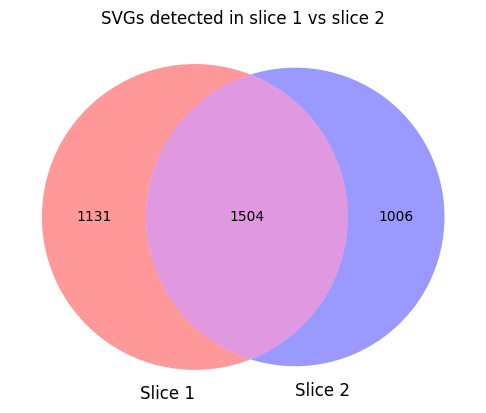

In [16]:
common_1_2 = list(set(svg_list_1) & set(svg_list_2))  # in 1 and 2
unique_1 = list(set(svg_list_1) - set(svg_list_2))  # only in 1
unique_2 = list(set(svg_list_2) - set(svg_list_1))  # only in 2

venn2(subsets=(len(unique_1), len(unique_2), len(common_1_2)),
      set_labels=('Slice 1', 'Slice 2'), set_colors=("red", "blue"))
plt.title("SVGs detected in slice 1 vs slice 2")
# plt.savefig(save_dir + f'svg_inter_1.{file_format}')
plt.show()

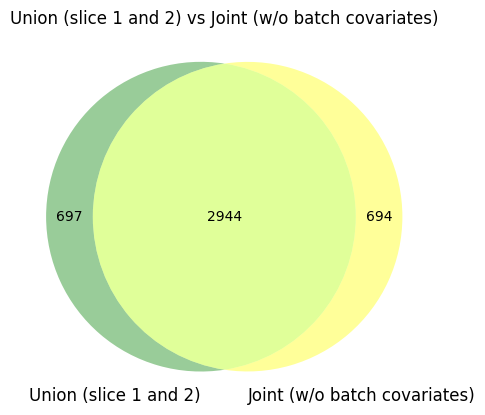

In [17]:
union_12 = list(set(svg_list_1) | set(svg_list_2))  # in 1 or 2
common_12_3 = list(set(union_12) & set(svg_list_wo))  # in 1 or 2 and in 3
unique_3 = list(set(svg_list_wo) - set(union_12))  # only in 3
unique_12 = list(set(union_12) - set(svg_list_wo))  # only in 1 or 2

venn2(subsets=(len(unique_12), len(unique_3), len(common_12_3)),
      set_labels=('Union (slice 1 and 2)', 'Joint (w/o batch covariates)'), set_colors=("green", "yellow"))
plt.title("Union (slice 1 and 2) vs Joint (w/o batch covariates)")
# plt.savefig(save_dir + f'svg_inter_2.{file_format}')
plt.show()

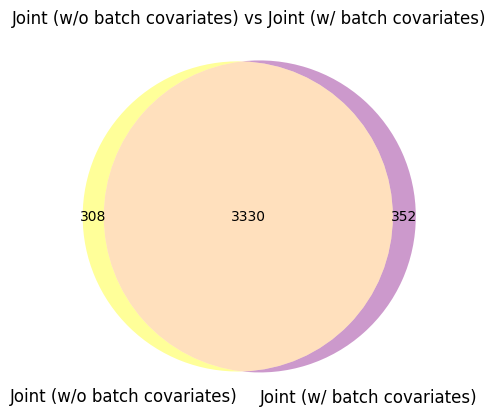

In [18]:
common_3_4 = list(set(svg_list_wo) & set(svg_list_w))  # in 3 and 4
unique_3 = list(set(svg_list_wo) - set(svg_list_w))  # only in 3
unique_4 = list(set(svg_list_w) - set(svg_list_wo))  # only in 4

venn2(subsets=(len(unique_3), len(unique_4), len(common_3_4)),
      set_labels=('Joint (w/o batch covariates)', 'Joint (w/ batch covariates)'), set_colors=("yellow", "purple"))
plt.title("Joint (w/o batch covariates) vs Joint (w/ batch covariates)")
# plt.savefig(save_dir + f'svg_inter_3.{file_format}')
plt.show()

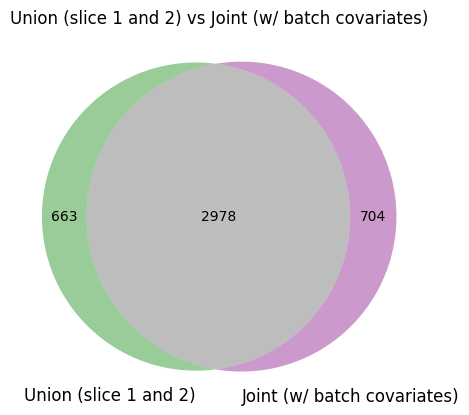

In [27]:
common_12_4 = list(set(union_12) & set(svg_list_w))  # in 1 or 2 and in 4
unique_12 = list(set(union_12) - set(svg_list_w))  # only in 1 or 2
unique_4 = list(set(svg_list_w) - set(union_12))  # only in 4

venn2(subsets=(len(unique_12), len(unique_4), len(common_12_4)),
      set_labels=('Union (slice 1 and 2)', 'Joint (w/ batch covariates)'), set_colors=("green", "purple"))
plt.title("Union (slice 1 and 2) vs Joint (w/ batch covariates)")
# plt.savefig(save_dir + f'svg_inter_4.{file_format}')
plt.show()

In [19]:
from plot_utils import plot_gene_expression
selected_list = ['HLA-B', 'EEF1A1', 'ERBB2', 'MMP14', 'CD44', 'FN1', 'DCN']
differ_list = ['PIP', 'SCGB2A2', 'ARPC5', 'CNIH4', 'SOD1', 'COX7C', 'PSMB3', 'JTB']

HLA-B
6.2216694369684826e-15
3.683574996096739e-15
4.5824708148163646e-14
4.490968643393591e-15


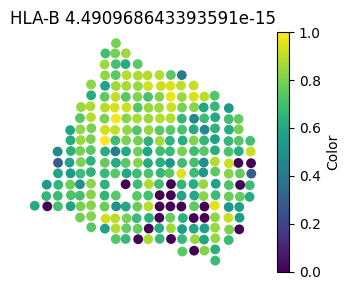

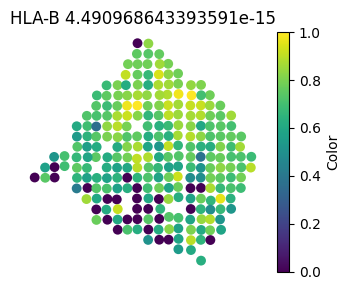

EEF1A1
5.795934916197134e-06
5.509526321174457e-07
4.598653771236781e-06
3.770926549194517e-07


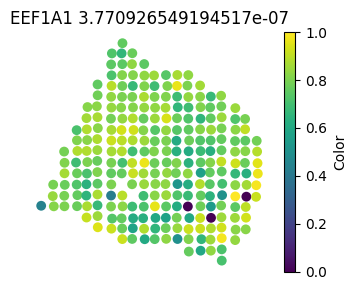

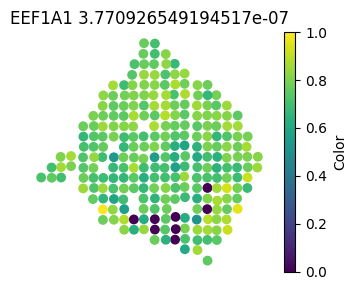

ERBB2
7.347050714706131e-06
5.003080475923859e-06
1.0388041683757504e-07
9.061896842721262e-08


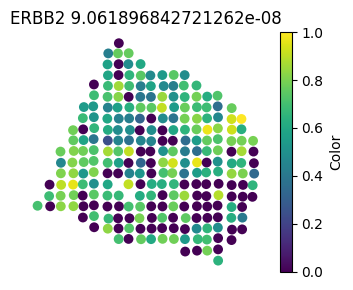

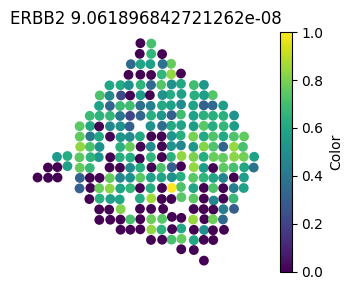

MMP14
4.5930383740270587e-07
0.0001285436865859
1.7068160268108343e-09
1.6579478080261792e-09


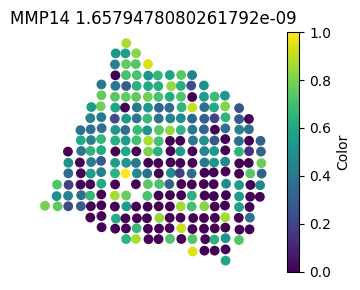

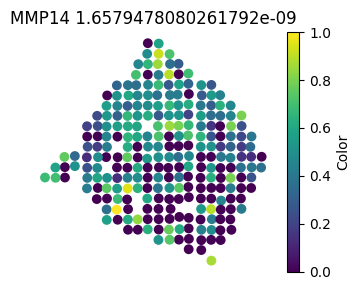

CD44
0.0056552140284849
0.0010177764152236
0.0001597405914664
9.2196657467501e-05


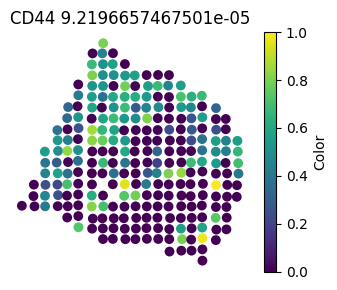

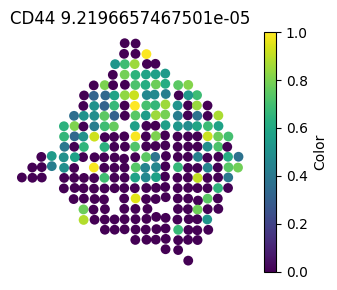

FN1
1.7483157951452714e-15
3.698428121081e-15
3.9718963907246425e-15
1.5882427255897632e-14


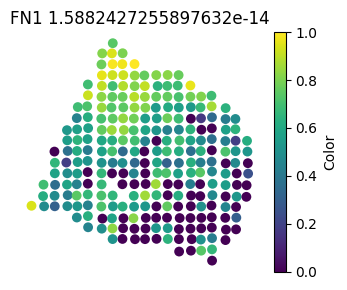

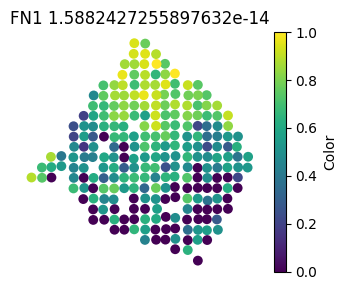

DCN
9.939682623214292e-11
6.5551592560354706e-15
5.056111209112631e-15
4.995443037851896e-15


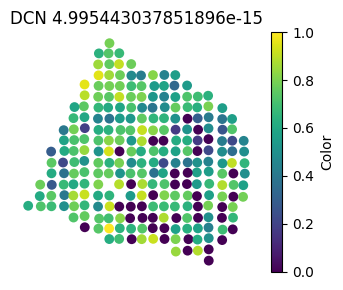

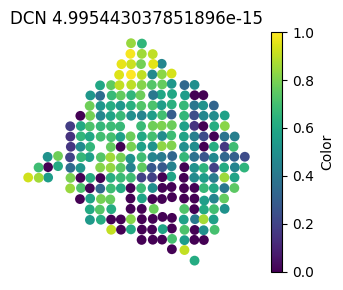

PIP
6.592058757297809e-06
1.0
7.454997706499467e-05
0.0001932049238867


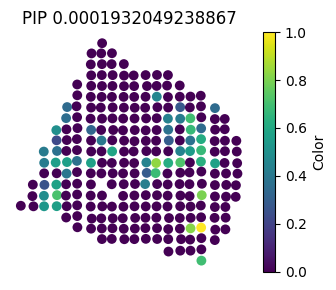

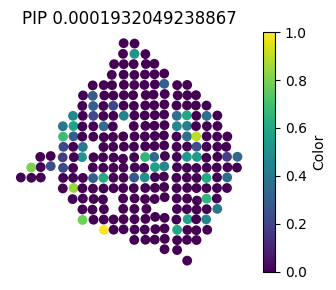

SCGB2A2
0.3058411108467687
7.987863017742271e-06
3.991935036531904e-05
3.955244428031445e-05


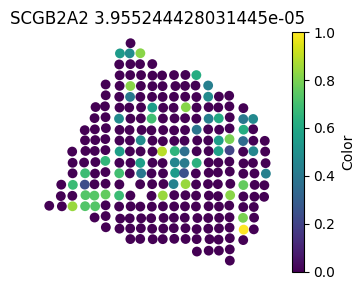

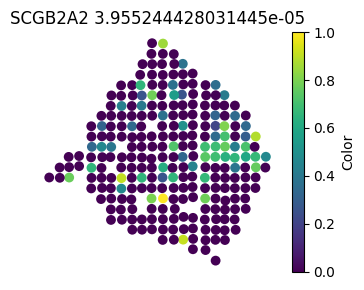

ARPC5
1.0
0.0185026873241831
0.0285013744168098
0.0062442981310753


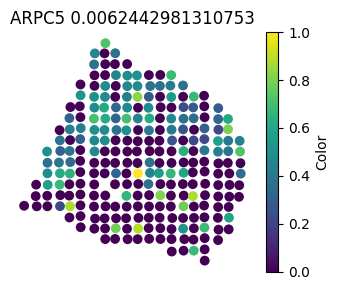

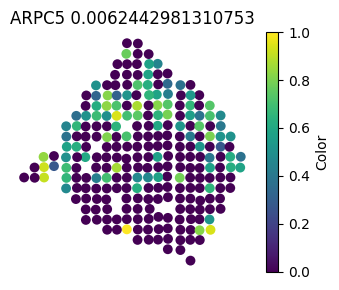

CNIH4
0.0469559645695895
1.0
1.0
5.1622916787847915e-15


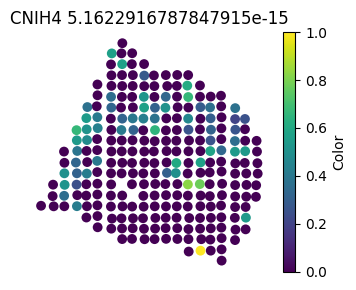

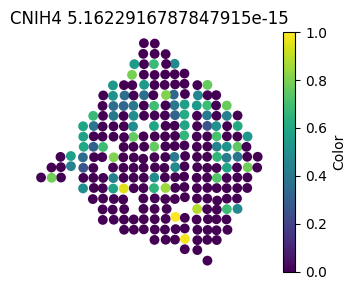

SOD1
0.5973984078132377
1.0
0.9138608447713864
0.007491109964009


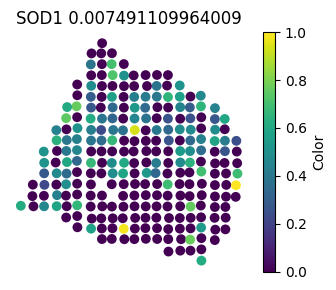

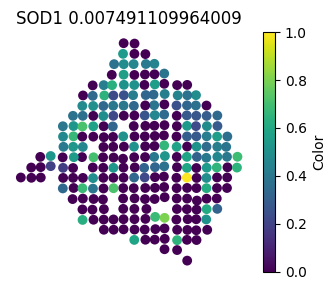

COX7C
1.0
0.407739048697103
1.0
2.4144485445628522e-12


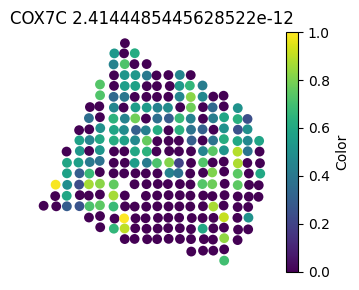

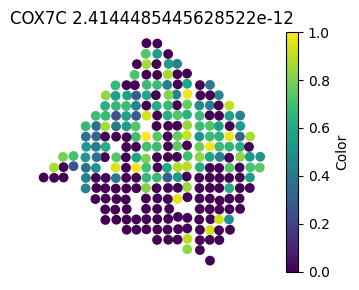

PSMB3
0.2067798319215109
1.0
1.0
1.0617847889499464e-10


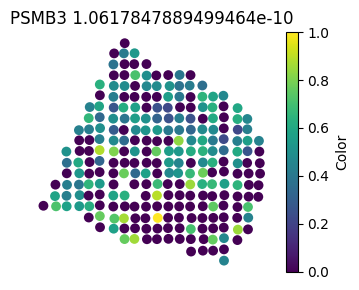

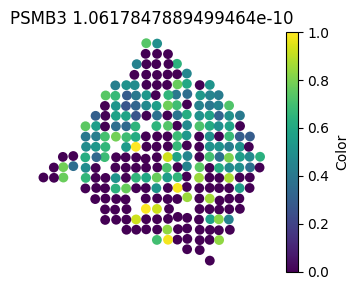

JTB
1.0
1.0
0.0324641771497747
0.0002294238171378


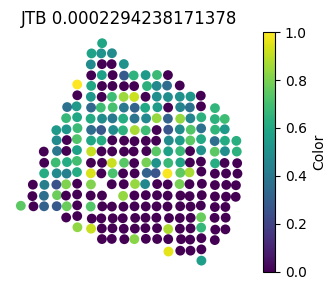

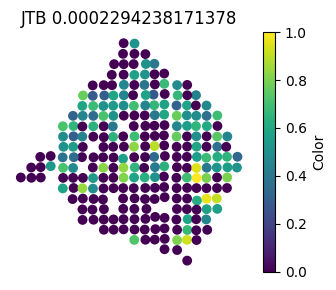

In [23]:
file_format = 'png'
for gene in selected_list + differ_list:
    print(gene)
    print(df1['adj_p_values'][gene])
    print(df2['adj_p_values'][gene])
    print(df_wo['adj_p_values'][gene])
    print(df_w['adj_p_values'][gene])
    plot_gene_expression(adata1_common, 'spatial', gene, log_norm=True, y_inverse=True,
                         cmap='viridis', figsize=(3.5, 3), s=200,
                         titlesize=12, norm0to1=True, title=f"{gene} {str(df_w['adj_p_values'][gene])}", 
                         save_path=save_dir + f'{gene}_1.{file_format}', save=False, show=True)
    plot_gene_expression(adata2_common, 'spatial', gene, log_norm=True, y_inverse=True,
                         cmap='viridis', figsize=(3.5, 3), s=200,
                         titlesize=12, norm0to1=True, title=f"{gene} {str(df_w['adj_p_values'][gene])}", 
                         save_path=save_dir + f'{gene}_2.{file_format}', save=False, show=True)

In [59]:
unique_4_123 = list(set(svg_list_w) - set(svg_list_wo) - set(svg_list_1) - set(svg_list_2)) 
len(unique_4_123)

85